<a href="https://colab.research.google.com/github/jeet1912/ms/blob/main/ds675/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Note to grader:** Each question consists of parts, e.g. Q1(i), Q1(ii), etc. Each part must be graded on scale of 0-4 scale, following the standard NJIT convention (A: 4, B+: 3.5, B: 3, C+: 2.5, C: 2, D: 1, F: 0).

The total score must be re-scaled to 100 so that Canvas gives the same weight to Assignments 2-6.

For questions stated as being worth 8 points, grade on a 0-4 scale, and multiply by 2.

In [ ]:
# Grader's area
import numpy as np
M = np.zeros([10,10])
maxScore = 0


# **Assignment 3**

The goal in this assignment to work a little more with Python, do some practice with logistic regression, and reflect on how it can fail to work on linearly separable data. You will also work with a support vector classifier. All that, still on "toy" data sets.

We will work with the first 'real' data sets in the next assignment.

**You may use ChatGPT or other LLMs to help with this assignment.** (Unless the question specifically requests it, the use of LLMs is **optional**.) However, if you do use an LLM to help with a particular question, you must submit a full transcript of all your interactions with the LLM in the form of screenshots embedded in the text cells provided. (Alternatively, if the LLM allows links to the transcripts to be shared, then you can place such links in the text cells instead. Please make sure that the links work!) You must also do this on your own &mdash; using the results of another person's LLM session, or sharing your session with another student, are not acceptable. In your answer, you should also state how you were able to make use of the LLM's responses.

Here is an example of what a ChatGPT transcript looks like. Note that the transcript includes the full output as well as the user prompt that generated the ChatGPT response. Please use a separate text cell for each image you embed.

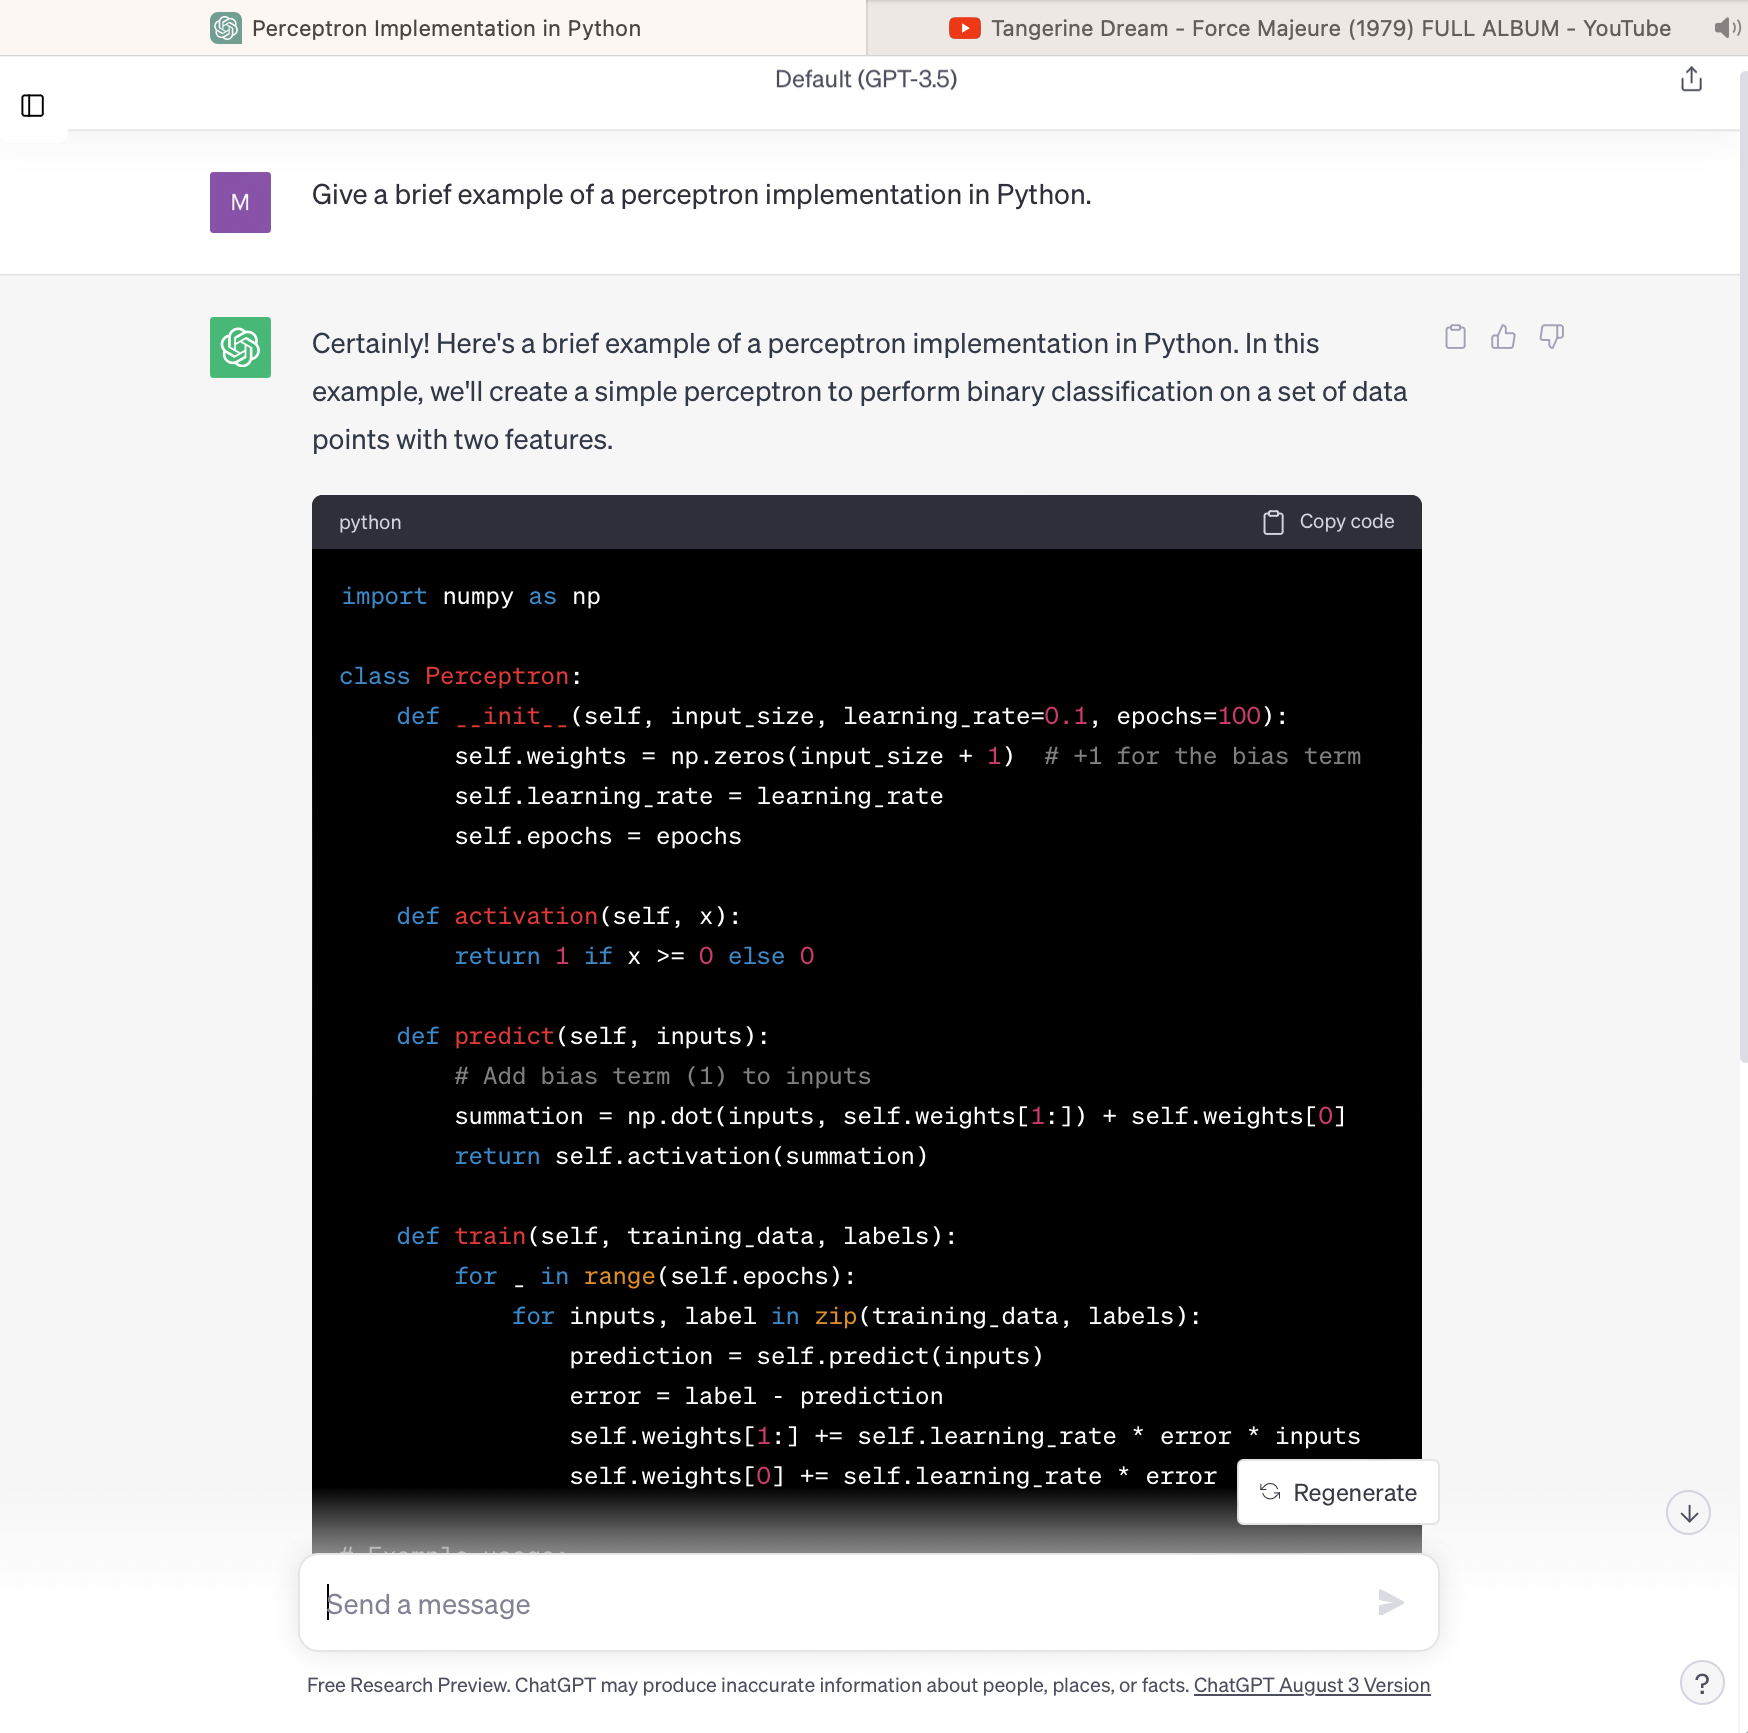

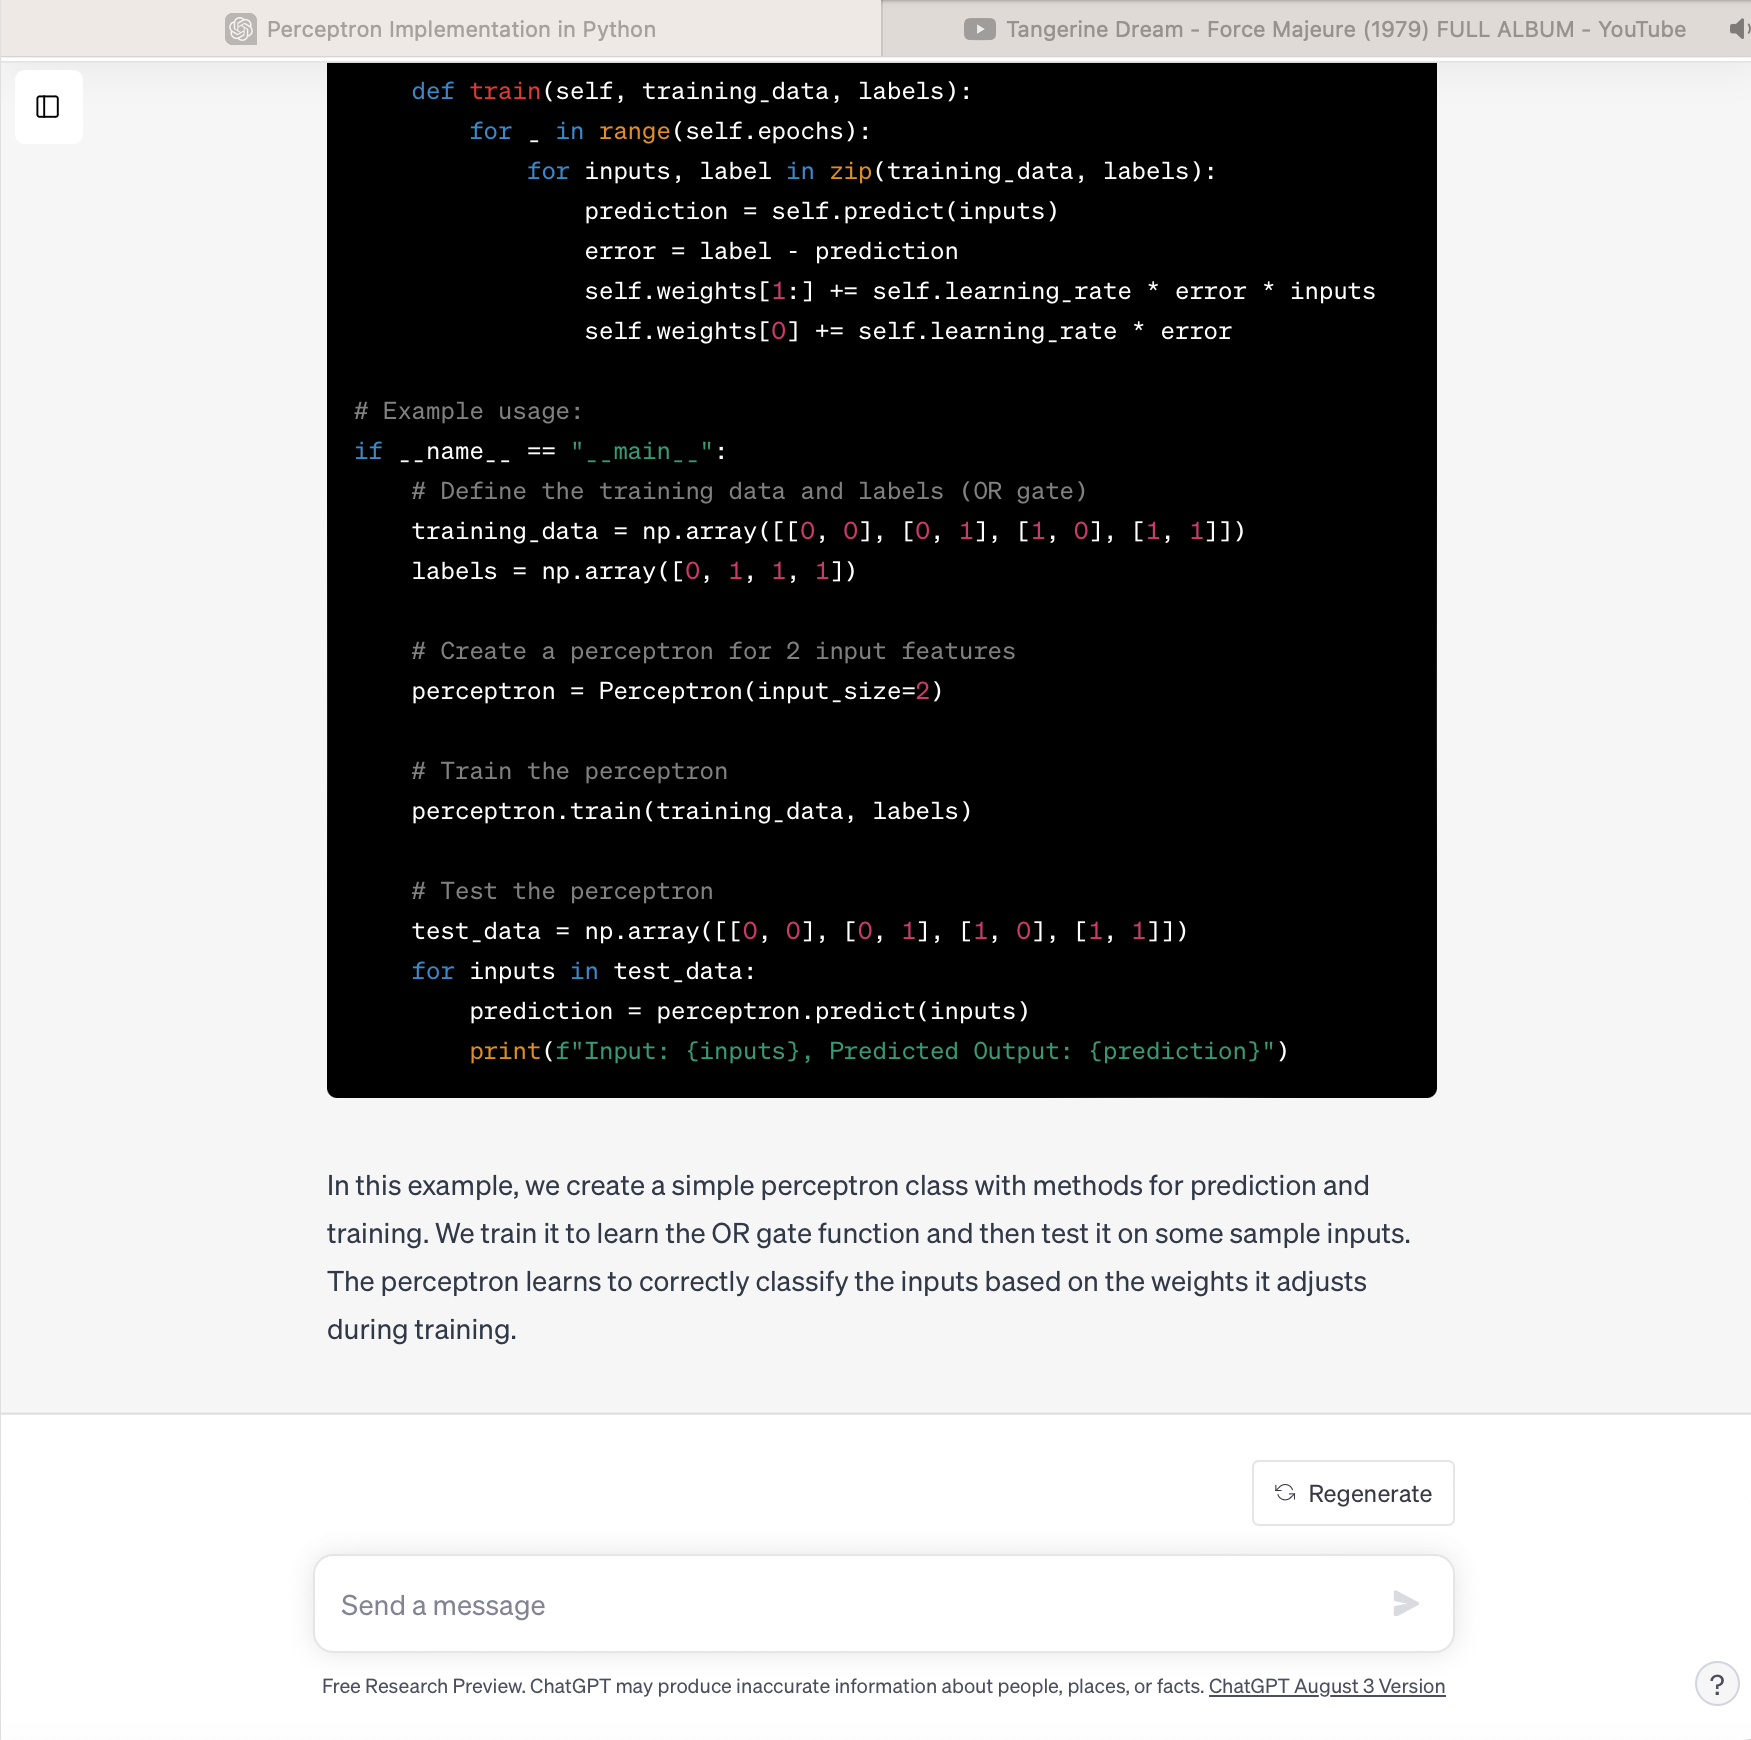

## **Preparation Steps**

In [ ]:
# Import all necessary python packages
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression

from IPython.display import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ### Reading-in the Iris data

s = os.path.join('https://archive.ics.uci.edu', 'ml',
                 'machine-learning-databases', 'iris','iris.data')
s = s.replace("\\","/");
print('URL:', s)
df = pd.read_csv(s,header=None,encoding='utf-8')


URL: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


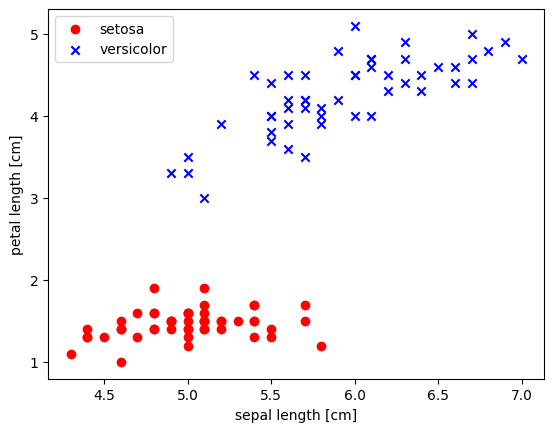

In [ ]:
# select setosa and versicolor for binary classification
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)

# extract sepal length and petal length
X = df.iloc[:100, [0, 2]].values

# plot data
plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='x', label='versicolor')

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')


# plt.savefig('images/02_06.png', dpi=300)
plt.show()

In [ ]:
# function for visualizing decision regions

from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor='black')

-----------------------
-----------------------
-----------------------


## <font color = 'blue'> **Question 1. Practice with logistic regression** </font>

First, let's load a slightly modified version of the textbook's implementation of logistic regression with gradient descent.

In [ ]:
class LogisticRegressionGD(object):
    """Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    loss_ : list
      Logistic loss function value in each epoch.

    """
    def __init__(self, eta=0.05, n_iter=100, random_state=1, initial_weights=None):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        self.initial_weights = initial_weights
        ##Added my code
        if self.initial_weights is not None:
            self.w_ = np.array(self.initial_weights)
        else:
            self.w_ = None

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """

        if self.w_ is None:
          rgen = np.random.RandomState(self.random_state)
          self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.loss_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()

            # Clip the values of 'output' to avoid divide-by-zero errors
            output = np.clip(output, 1e-10, 1 - 1e-10)

            # compute the logistic `loss`
            loss = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.loss_.append(loss)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        # equivalent to:
        # return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

Below you can see the first 3 data points of the data set, all labeled as 'setosa'. Let's set the numerical value for 'setosa' to 1. (i.e. y = 1).

In [ ]:
X[0:3]

array([[5.1, 1.4],
       [4.9, 1.4],
       [4.7, 1.3]])

In [ ]:
y[0:3]

array([-1, -1, -1])

Suppose the initial weights of the logistic neuron are w0 = 0.1, w1 = -0.3, w2 = 0.2.

<font color = 'blue'> **Q1-1**.  </font> Write the weights after processing data points 0,1,2, with learning rate $\eta=0.1$ and show your calculations. This is similar to the previous assignment, only done now for the logistic neuron. You can also use *LogisticRegressionGD* to check your calculations. <br>

<font color = 'blue'> **Q1-2**.  </font> Given our data $X$, let $X_{d=2}$ and $X_{d=3}$ be the quadratic and cubic features. Using code for polynomial regression from the Regression Code Notebook, generate $X_{d=2}$ and $X_{d=3}$.

<font color = 'blue'> **Q1-3**.  </font> Using *LogisticRegressionGD*, fit $X$, $X_{d=2}$ and $X_{d=3}$. Here you should set $\eta \leq 0.001$ and $n_{\mathit{iter}} \geq 1000$. For each of these three cases, report the loss function value for the model computed by *LogisticRegressionGD*. Explain why your program produces the loss values you observe.

<font color = 'blue'> **Q1-4**.  </font> Copy the code for our class *LogisticRegressionGD* into a new cell, and modify so that it uses L2 regularization. (**Note:** You will need to update the parameter weight update rule for gradient descent.) Give your copy the new name *LogisticRegressionGDwithReg*, and make sure that every new line of code you add is clearly commented.

<font color = 'blue'> **Q1-5**.  </font>
Redo Q1-3 using *LogisticRegressionGDwithReg* with $\lambda\in\{0.0, 0.1,\ldots, 0.9\}$, for the same input choices and hyperparameter choices from Q1-3. For each case, report the loss function value and the norm of the weight parameter vector. What trends do you observe?

(If for this question you have used LLMs such as ChatGPT, replace this text by screenshots of the full transcript of your session. Create extra text cells if needed.)

In [ ]:
w0 = 0.1
w1 = -0.3
w2 = 0.2
eta = 0.1

In [ ]:
x = X[0:3]
y_here = y[0:3]

#set setosa to 1, so versicolor is 0.
y_here = np.where(y_here < 0, 1, 0)
w = np.asarray([w1, w2])

In [ ]:
x

array([[5.1, 1.4],
       [4.9, 1.4],
       [4.7, 1.3]])

In [ ]:
y_here

array([1, 1, 1])

In [ ]:
def activation(z):
      """Compute logistic sigmoid activation"""
      return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

### Q1-1

In [ ]:
for j in range(len(x)):
  print('This is #{} point'.format(j))
  print('W0 is {}, x is {} and weights are {}'.format(w0,x[j],w))
  z = w0 + np.dot(x[j],w)
  z = activation(z)
  error = z - y_here[j]
  print('Error is {}'.format(error))
  w0 = w0 - eta*error
  for k in range(len(w)):
    w[k] = w[k] - eta*error*x[j][k]
  print('Updated bias is {}'.format(w0))
  print('Updated weights are {}'.format(w))

This is #0 point
W0 is 0.1, x is [5.1 1.4] and weights are [-0.3  0.2]
Error is -0.759510916949111
Updated bias is 0.1759510916949111
Updated weights are [0.08735057 0.30633153]
This is #1 point
W0 is 0.1759510916949111, x is [4.9 1.4] and weights are [0.08735057 0.30633153]
Error is -0.26253523429011605
Updated bias is 0.2022046151239227
Updated weights are [0.21599283 0.34308646]
This is #2 point
W0 is 0.2022046151239227, x is [4.7 1.3] and weights are [0.21599283 0.34308646]
Error is -0.159308348175892
Updated bias is 0.2181354499415119
Updated weights are [0.29086776 0.36379655]


In [ ]:
w0 = 0.1
w1 = -0.3
w2 = 0.2
initial_weights = [w0, w1, w2]
updated = initial_weights

for i in range(len(x)):
  lr = LogisticRegressionGD(eta = eta, n_iter=1, random_state=1, initial_weights=updated)
  lr.fit(x[i:i+1],y_here[i:i+1])
  updated = lr.w_

updated

array([0.21813545, 0.29086776, 0.36379655])

### Q1-2

In [ ]:
y_LR = np.where(y<0,1,0) #setosa as 1 for LogReg

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)

X2 = quadratic.fit_transform(X)
X3 = cubic.fit_transform(X)

### Q1-3

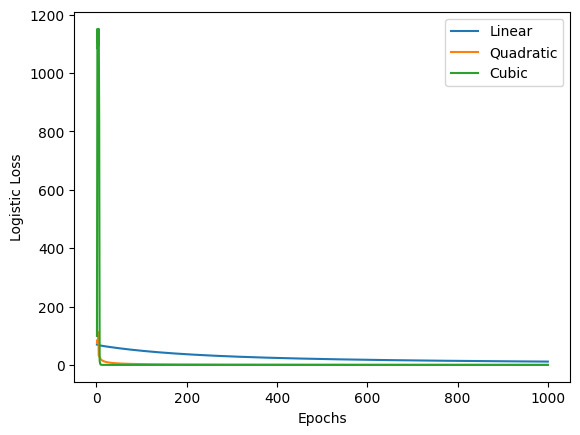

In [ ]:
logReg = LogisticRegressionGD(eta=0.0001, n_iter=1000, random_state=42)
logRegQ = LogisticRegressionGD(eta=0.0001, n_iter=1000, random_state=42)
logRegC = LogisticRegressionGD(eta=0.0001, n_iter=1000, random_state=42)

logReg.fit(X,y_LR)
logRegQ.fit(X2,y_LR)
logRegC.fit(X3,y_LR)

plt.plot(range(1, len(logReg.loss_) + 1), logReg.loss_, label='Linear')
plt.plot(range(1, len(logRegQ.loss_) + 1), logRegQ.loss_, label='Quadratic')
plt.plot(range(1, len(logRegC.loss_) + 1), logRegC.loss_, label='Cubic')
plt.xlabel('Epochs')
plt.ylabel('Logistic Loss')
plt.legend(loc='upper right')
plt.show()

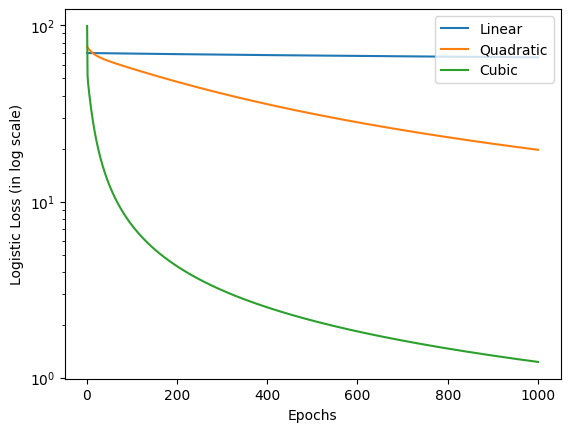

In [ ]:
logReg = LogisticRegressionGD(eta=0.000001, n_iter=1000, random_state=42)
logRegQ = LogisticRegressionGD(eta=0.000001, n_iter=1000, random_state=42)
logRegC = LogisticRegressionGD(eta=0.000001, n_iter=1000, random_state=42)

logReg.fit(X,y_LR)
logRegQ.fit(X2,y_LR)
logRegC.fit(X3,y_LR)

plt.plot(range(1, len(logReg.loss_) + 1), logReg.loss_, label='Linear')
plt.plot(range(1, len(logRegQ.loss_) + 1), logRegQ.loss_, label='Quadratic')
plt.plot(range(1, len(logRegC.loss_) + 1), logRegC.loss_, label='Cubic')
plt.xlabel('Epochs')
plt.ylabel('Logistic Loss (in log scale)')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

In [ ]:
logReg.loss_[-1]

65.88912214544311

In [ ]:
logRegQ.loss_[-1]

19.68106358763737

In [ ]:
logRegC.loss_[-1]

1.2299555209683724

*   All the models drop drastically during the initial set of epochs, with the cubic one dropping the steepest, implying that it quickly reduces the error at the beginning.
* After a certain point, the convergence rate of each model reduces and almost becomes a plateau.
*   We observe lowest values of loss function for the cubic model in later stages, which may imply that it is the best model for our training data as learning on the cubic transformation helps us capture hidden patterns. But, if we look at the distribution of our data in the scatter plot, we can understand intuitively that a linear model should suffice. So I think, the cubic model may lead to overfitting.

### Q1-4

In [ ]:
class LogisticRegressionGDwithReg(object):
    """Logistic Regression Classifier using gradient descent with L2 regularization.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight initialization.
    lambda_ : float
      Regularization parameter.
    initial_weights : array-like
      Initial weights for the model.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    loss_ : list
      Logistic loss function value in each epoch.

    """
    def __init__(self, eta=0.05, n_iter=100, random_state=1, lambda_=0.1, initial_weights=None):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        self.lambda_ = lambda_
        self.initial_weights = initial_weights
        if self.initial_weights is not None:
            self.w_ = np.array(self.initial_weights)
        else:
            self.w_ = None

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        if self.w_ is None:
            rgen = np.random.RandomState(self.random_state)
            self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.loss_ = []

        for _ in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            # Update weights with L2 regularization; w_[0] is the bias (intercept), not regularized
            self.w_[1:] += self.eta * (X.T.dot(errors) - self.lambda_ * self.w_[1:])
            self.w_[0] += self.eta * errors.sum()
            output = np.clip(output, 1e-10, 1 - 1e-10)
            # loss with L2 regularization term
            loss = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output))) + (self.lambda_) * np.sum(np.square(self.w_[1:]))
            self.loss_.append(loss)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)

    def get_weight_norm(self):
        # Return the L2 norm of the weight vector (not including the bias term)
        return np.linalg.norm(self.w_[1:])


### Q1-5

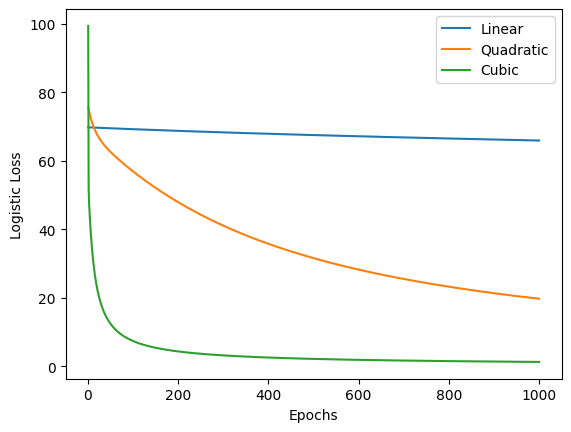

In [ ]:
logRegR = LogisticRegressionGDwithReg(eta=0.000001, n_iter=1000, random_state=42)
logRegQR = LogisticRegressionGDwithReg(eta=0.000001, n_iter=1000, random_state=42)
logRegCR = LogisticRegressionGDwithReg(eta=0.000001, n_iter=1000, random_state=42)

logRegR.fit(X,y_LR)
logRegQR.fit(X2,y_LR)
logRegCR.fit(X3,y_LR)

plt.plot(range(1, len(logRegR.loss_) + 1), logRegR.loss_, label='Linear')
plt.plot(range(1, len(logRegQR.loss_) + 1), logRegQR.loss_, label='Quadratic')
plt.plot(range(1, len(logRegCR.loss_) + 1), logRegCR.loss_, label='Cubic')
plt.xlabel('Epochs')
plt.ylabel('Logistic Loss') #(in log scale)
#plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

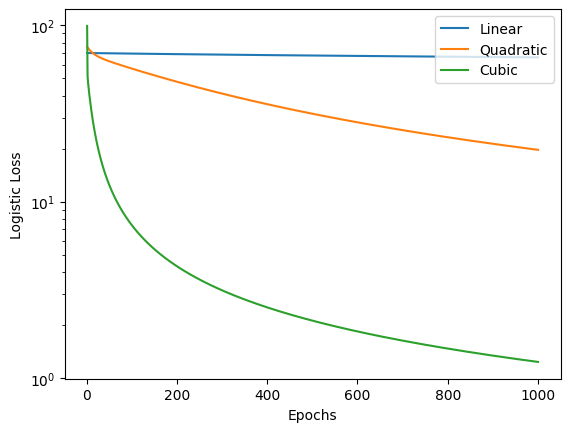

In [ ]:
logRegR = LogisticRegressionGDwithReg(eta=0.000001, n_iter=1000, random_state=42)
logRegQR = LogisticRegressionGDwithReg(eta=0.000001, n_iter=1000, random_state=42)
logRegCR = LogisticRegressionGDwithReg(eta=0.000001, n_iter=1000, random_state=42)

logRegR.fit(X,y_LR)
logRegQR.fit(X2,y_LR)
logRegCR.fit(X3,y_LR)

plt.plot(range(1, len(logRegR.loss_) + 1), logRegR.loss_, label='Linear')
plt.plot(range(1, len(logRegQR.loss_) + 1), logRegQR.loss_, label='Quadratic')
plt.plot(range(1, len(logRegCR.loss_) + 1), logRegCR.loss_, label='Cubic')
plt.xlabel('Epochs')
plt.ylabel('Logistic Loss')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

In [ ]:
final_loss_C = logRegC.loss_[-1]
print(final_loss_C)
final_loss_RegC = logRegCR.loss_[-1]
print(final_loss_RegC)

1.2299555209683724
1.2317502961429398


In [ ]:
final_loss_Q = logRegQ.loss_[-1]
print(final_loss_Q)
final_loss_RegQ = logRegQR.loss_[-1]
print(final_loss_RegQ)

19.68106358763737
19.68618440972853


In [ ]:
final_loss = logReg.loss_[-1]
print(final_loss)
final_loss_Reg = logRegR.loss_[-1]
print(final_loss_Reg)

65.88912214544311
65.88954292162562


One clear distinction we can observe is that the loss tends to plateau at a higher level, implying a slower convergence rate as higher weights are penalised by regularization. Therefore, it tends to reduce overfitting on training data. Wheras the overall trend accross different models is still the same. Let's plot them.

In [ ]:
lambda_values = np.arange(0.1, 1.0, 0.1)
weight_norms_linear = []
weight_norms_quadratic = []
weight_norms_cubic = []
loss_values_linear = []
loss_values_quadratic = []
loss_values_cubic = []


for lambda_ in lambda_values:

    model = LogisticRegressionGDwithReg(eta=0.000001, n_iter=1000, lambda_=lambda_, random_state=42)
    modelQ =  LogisticRegressionGDwithReg(eta=0.000001, n_iter=1000, lambda_=lambda_, random_state=42)
    modelC = LogisticRegressionGDwithReg(eta=0.000001, n_iter=1000, lambda_=lambda_, random_state=42)

    model.fit(X, y_LR)
    modelQ.fit(X2,y_LR)
    modelC.fit(X3,y_LR)

    loss_values_linear.append(model.loss_[-1])
    loss_values_quadratic.append(modelQ.loss_[-1])
    loss_values_cubic.append(modelC.loss_[-1])

    weight_norms_linear.append(model.get_weight_norm())
    weight_norms_quadratic.append(modelQ.get_weight_norm())
    weight_norms_cubic.append(modelC.get_weight_norm())


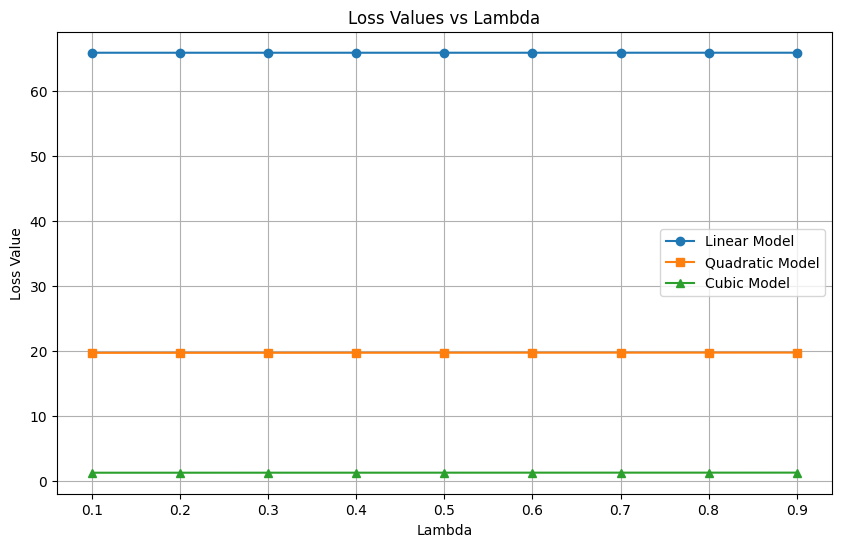

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(lambda_values, loss_values_linear, marker='o', label='Linear Model')
plt.plot(lambda_values, loss_values_quadratic, marker='s', label='Quadratic Model')
plt.plot(lambda_values, loss_values_cubic, marker='^', label='Cubic Model')

plt.title('Loss Values vs Lambda')
plt.xlabel('Lambda')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)
plt.show()


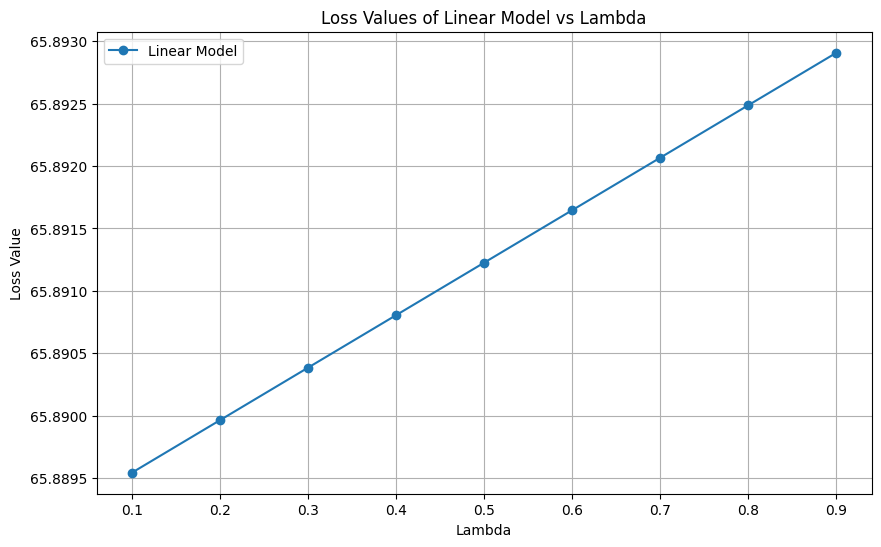

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(lambda_values, loss_values_linear, marker='o', label='Linear Model')
plt.title('Loss Values of Linear Model vs Lambda')
plt.xlabel('Lambda')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)
plt.show()

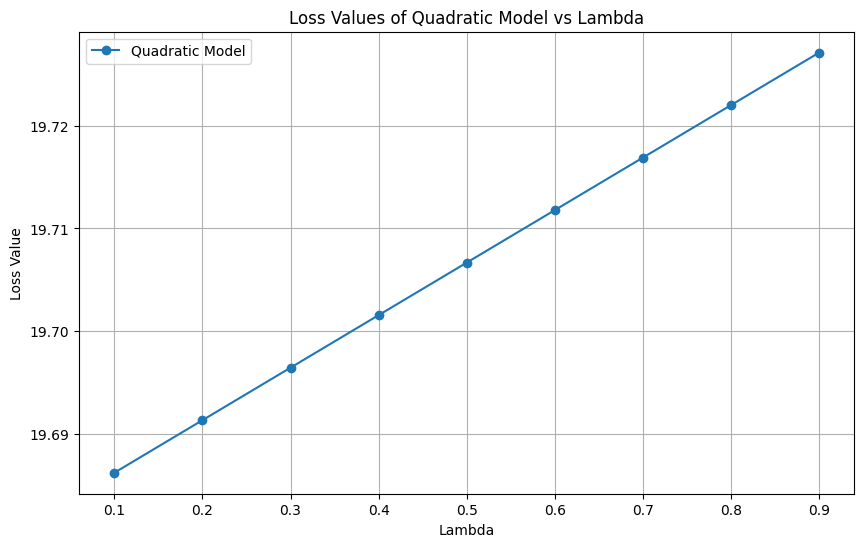

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(lambda_values, loss_values_quadratic, marker='o', label='Quadratic Model')
plt.title('Loss Values of Quadratic Model vs Lambda')
plt.xlabel('Lambda')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)
plt.show()

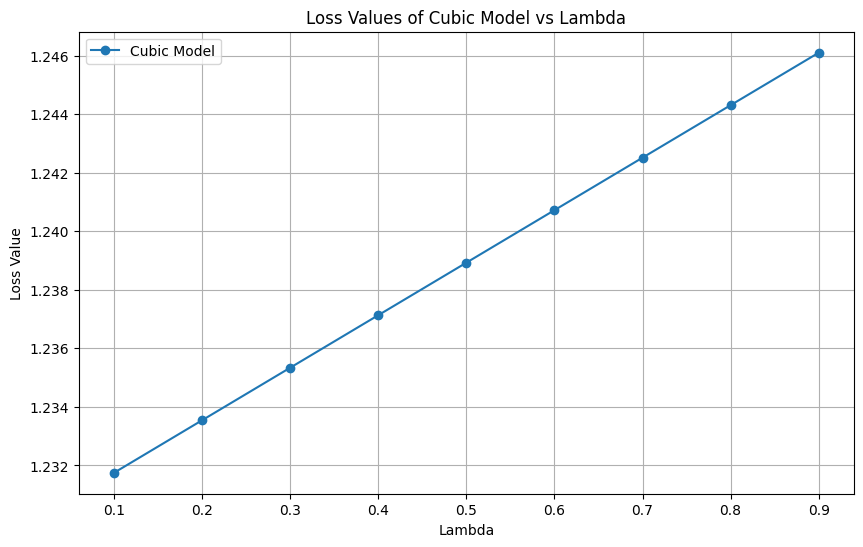

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(lambda_values, loss_values_cubic, marker='o', label='Cubic Model')
plt.title('Loss Values of Cubic Model vs Lambda')
plt.xlabel('Lambda')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)
plt.show()

### As lambda increases, the final loss values increase.

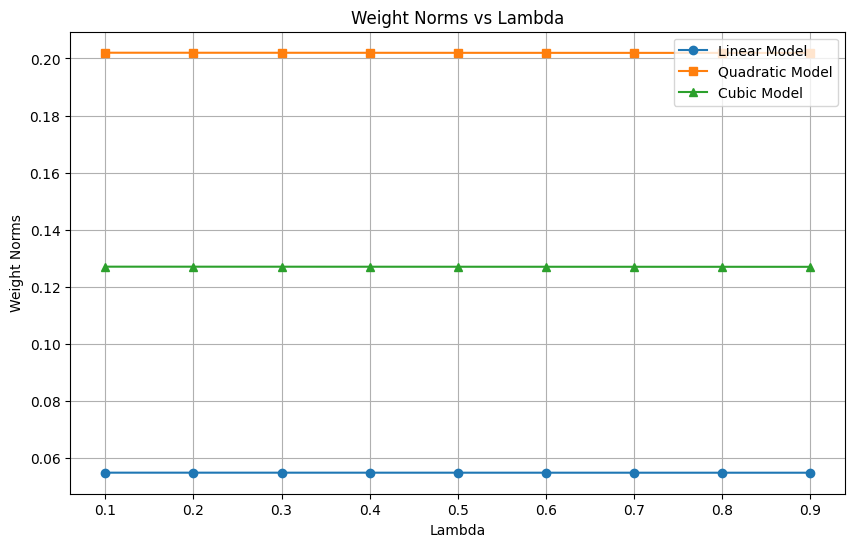

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(lambda_values, weight_norms_linear, marker='o', label='Linear Model')
plt.plot(lambda_values, weight_norms_quadratic, marker='s', label='Quadratic Model')
plt.plot(lambda_values, weight_norms_cubic, marker='^', label='Cubic Model')

plt.title('Weight Norms vs Lambda')
plt.xlabel('Lambda')
plt.ylabel('Weight Norms')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


The weight norm values of quadratic model are the heighest whereas those of linear model are the least for every lambda.

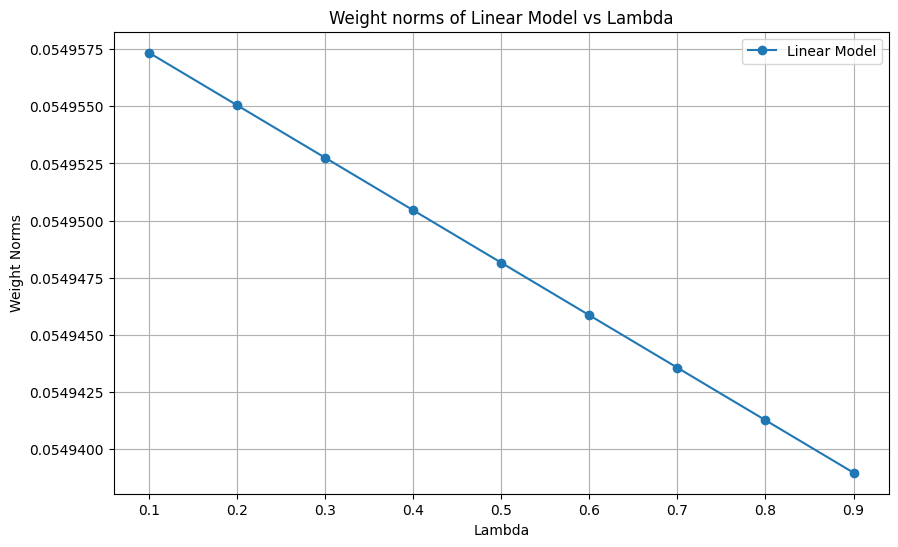

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(lambda_values, weight_norms_linear, marker='o', label='Linear Model')
plt.title('Weight norms of Linear Model vs Lambda')
plt.xlabel('Lambda')
plt.ylabel('Weight Norms')
plt.legend()
plt.grid(True)
plt.show()

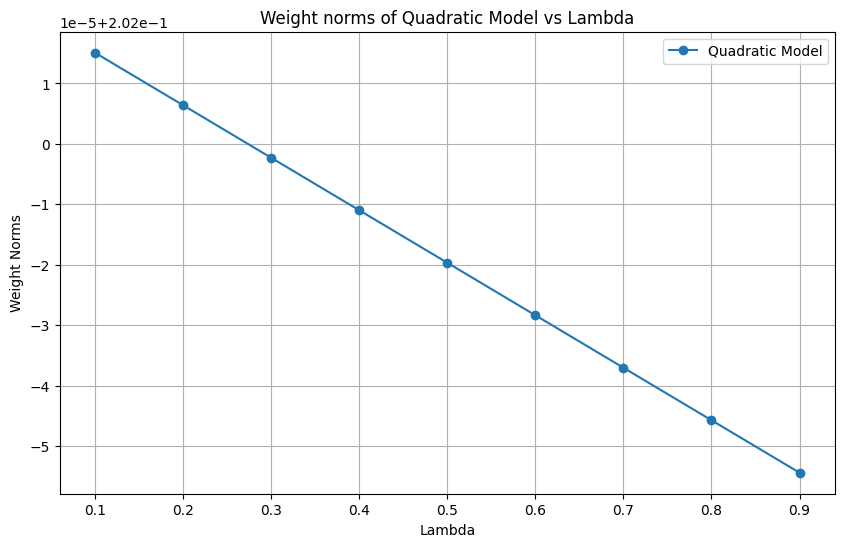

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(lambda_values, weight_norms_quadratic, marker='o', label='Quadratic Model')
plt.title('Weight norms of Quadratic Model vs Lambda')
plt.xlabel('Lambda')
plt.ylabel('Weight Norms')
plt.legend()
plt.grid(True)
plt.show()

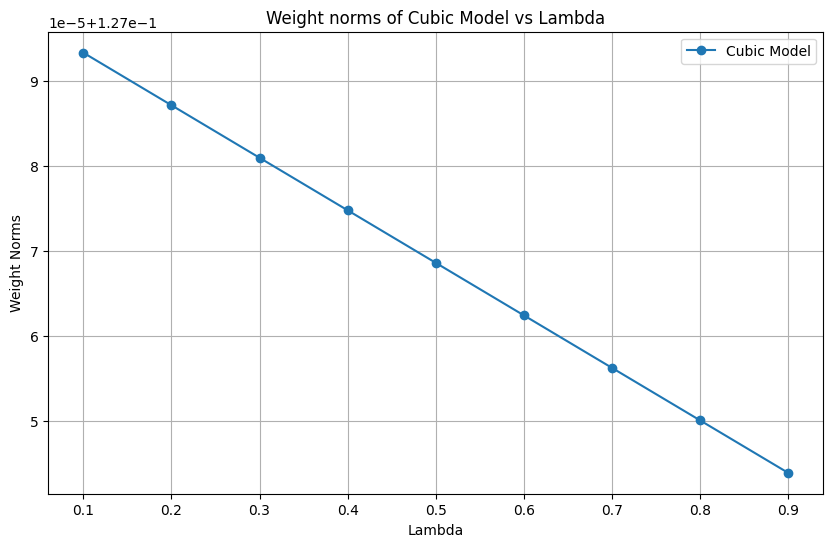

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(lambda_values, weight_norms_cubic, marker='o', label='Cubic Model')
plt.title('Weight norms of Cubic Model vs Lambda')
plt.xlabel('Lambda')
plt.ylabel('Weight Norms')
plt.legend()
plt.grid(True)
plt.show()

###Weight norm decreases with increasing lambda.

In [ ]:
# Grader's area

maxScore = maxScore +4
#M[1,1] =

maxScore = maxScore +4
#M[1,2] =

maxScore = maxScore +4
#M[1,3] =

maxScore = maxScore +4
#M[1,4] =

maxScore = maxScore +4
#M[1,5] =

-----------------------
-----------------------
-----------------------


## <font color = 'blue'> **Question 2. A theoretical question** </font>

This question is about a theoretical explanation for what you observed in question Q1-3.

<br>

Suppose that $f_1$ is a model that optimally fits the data $(X,y)$, and $f_2$ is another model that optimally fits the data $(X_2,y)$, where $X_2$ are the quadratic features of $X$. Then the loss function value obtained by $f_2$ is **always** going to be less than or equal to the loss obtained by $f_1$. Try to come up with a solid mathematical argument that justifies this claim. [**Note:** as with anything else, feel free to discuss this on Canvas.]

(If for this question you have used LLMs such as ChatGPT, replace this text by screenshots of the full transcript of your session. Create extra text cells if needed.)

(your answer goes here)

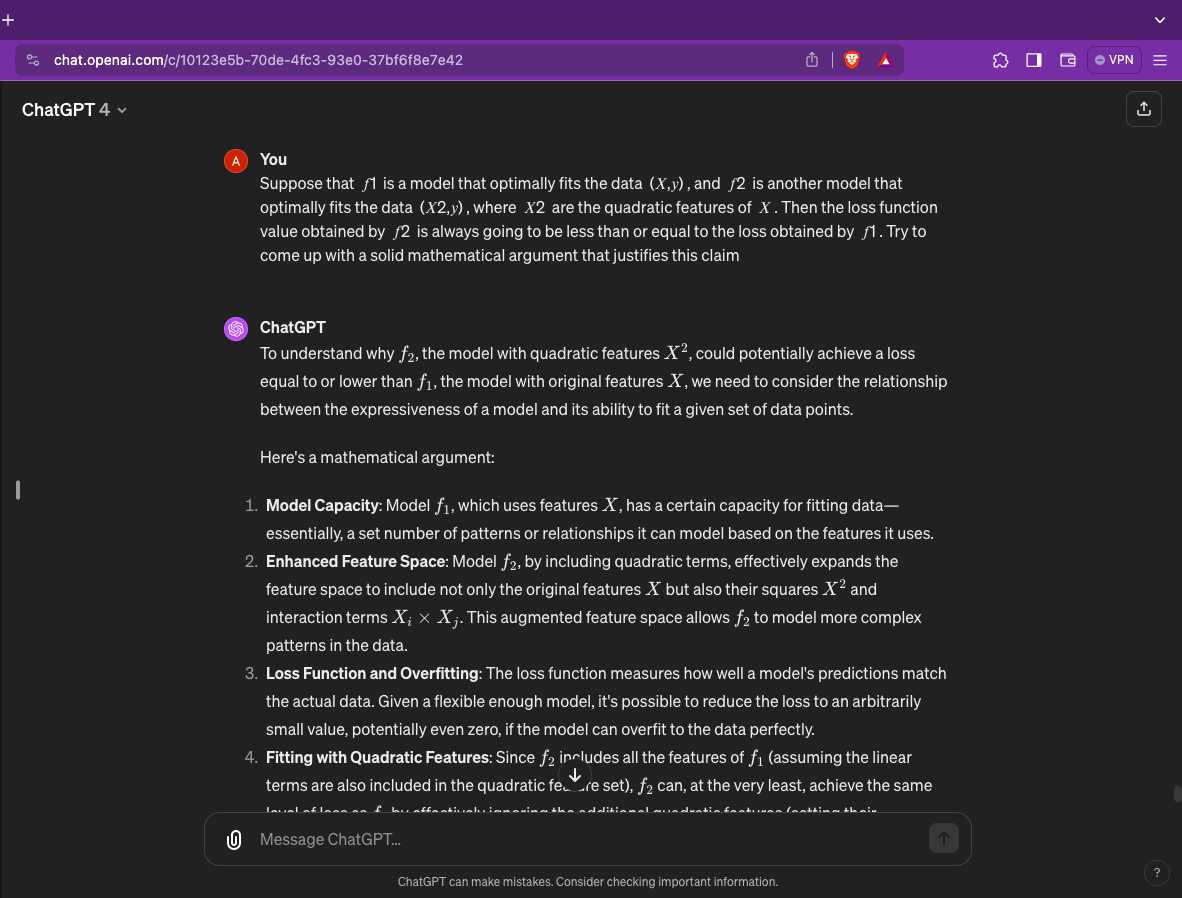

In [ ]:
Image('/content/drive/MyDrive/ML/assignment3/Screenshot 2024-03-10 at 3.19.38 PM.png')

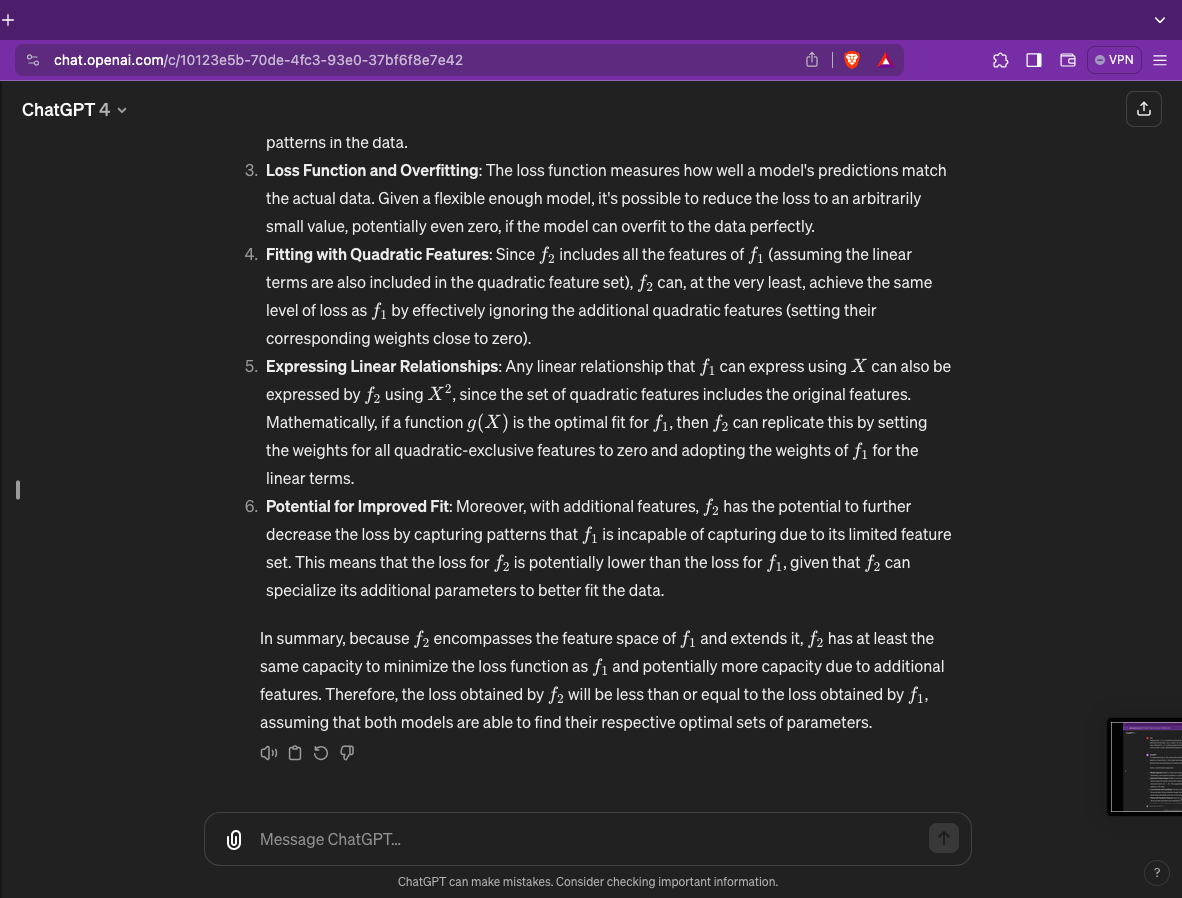

In [ ]:
Image('/content/drive/MyDrive/ML/assignment3/Screenshot 2024-03-10 at 3.19.44 PM.png')

In [ ]:
# Grader's area

maxScore = maxScore + 4
#M[2,1] =


-----------------------
-----------------------
-----------------------


##  <font color = 'blue'> **Question 3. Logistic Regression: How 'unfair' can it be?**  </font>

We have seen that the inductive bias of an SVC guarantees that when the dataset is linearly separable, SVC will return a hyperplane that is at exactly the same distance from the two classes.  But what about logistic regression? Can we guarantee that it can also be at least partially fair?

The answer is **no**. We can  demonstrate how logistic regression can be 'unfair' by constructing a dataset with the properties that: <br>

**a.** the data set is linearly separable, and  <br>
**b.** the optimal logistic regression model corresponds to a hyperplane that nearly 'touches' one of the two classes - that is, it has a very big margin with respect to one of the two classes, and a very small margin with respect to the other class.  <br>

Demonstrate your answer as follows: <br>

<font color = 'blue'> **Q3-1**.  </font>
 Plot the data points, as we did above for the Iris data set. This will show that your data set is linearly separable. <br>
<font color = 'blue'> **Q3-2**.  </font> Calculate the optimal logistic neuron weights using the function *LogisticRegressionGD* from Question 1. <br>
<font color = 'blue'> **Q3-3**. </font>  Plot the decision regions to demonstrate how the learned separation line is unfair.

**Hint**: Try small datasets. <br>
**Note**: It's best to use fresh variables for your dataset, since the previous values of $X,y$ will be reused in Question 4.


(If for this question you have used LLMs such as ChatGPT, replace this text by screenshots of the full transcript of your session. Create extra text cells if needed.)

In [ ]:
# your answers go here

### Q3-1

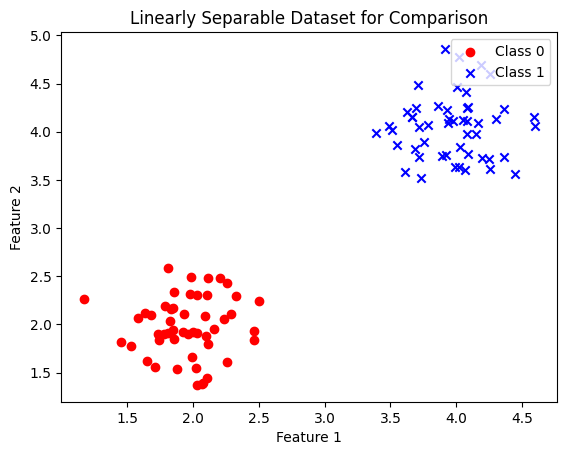

In [ ]:
# Seed for reproducibility
np.random.seed(42)

cluster_0 = np.random.multivariate_normal([2, 2], [[0.1, 0], [0, 0.1]], 50)
cluster_1 = np.random.multivariate_normal([4, 4], [[0.1, 0], [0, 0.1]], 50)

X_new = np.vstack((cluster_0, cluster_1))
y_new = np.hstack((np.zeros(cluster_0.shape[0]), np.ones(cluster_1.shape[0])))

plt.scatter(X_new[y_new == 0][:, 0], X_new[y_new == 0][:, 1], color='red', marker='o', label='Class 0')
plt.scatter(X_new[y_new == 1][:, 0], X_new[y_new == 1][:, 1], color='blue', marker='x', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Linearly Separable Dataset for Comparison')
plt.legend(loc='upper right')
plt.show()


### Q3-2

In [ ]:
lr_here = LogisticRegressionGD(eta=0.01)
lr_here.fit(X_new,y_new)

### Q3-3

<ipython-input-744-f03d03a89cdf>:26: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


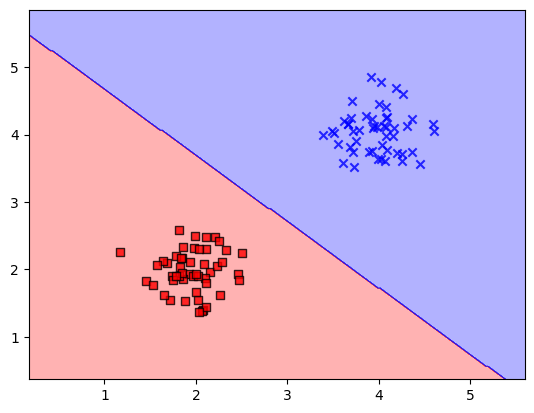

In [ ]:
plot_decision_regions(X_new,y_new, lr_here)

<ipython-input-744-f03d03a89cdf>:26: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


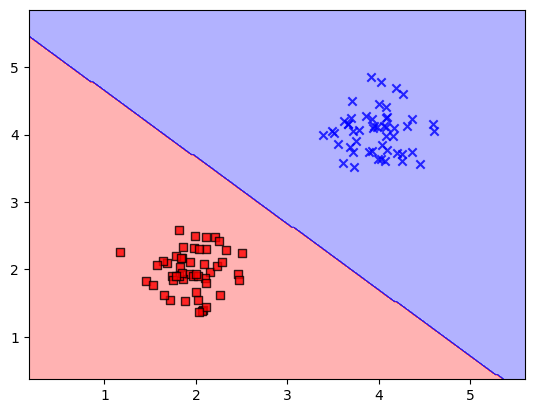

In [ ]:
lr_here = LogisticRegressionGD(eta=0.009)
lr_here.fit(X_new,y_new)
plot_decision_regions(X_new,y_new, lr_here)

Here, we can see that the boundary is closer to red.

<ipython-input-744-f03d03a89cdf>:26: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


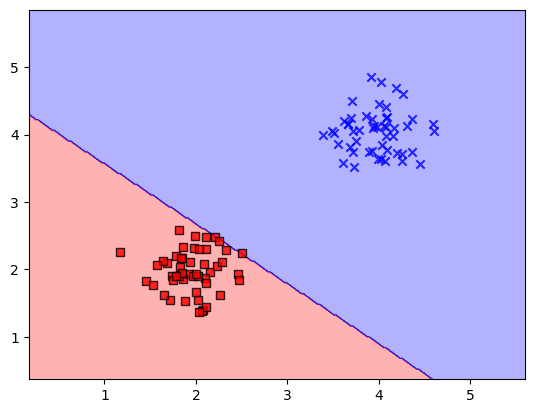

In [ ]:
lr_here = LogisticRegressionGD(eta=0.0015)
lr_here.fit(X_new,y_new)
plot_decision_regions(X_new,y_new, lr_here)

Here, the decision boundary passes through the points of red class.

In [ ]:
# Grader's area

maxScore = maxScore + 12
#M[3,1] =
#M[3,2] =
#M[3,3] =


<font color = 'blue'> **Q3-4**.  </font> The standard scikit-learn implementation of logistic regression uses regularization by default ($C=1$).  Can you come up with a linearly separable dataset that makes that **default** implementation fail? <br>

[Note: This is an experimental question. You should be able to use the example from above, or modify it, and make the default implementation fail.]

(If for this question you have used LLMs such as ChatGPT, replace this text by screenshots of the full transcript of your session. Create extra text cells if needed.)

<ipython-input-744-f03d03a89cdf>:26: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


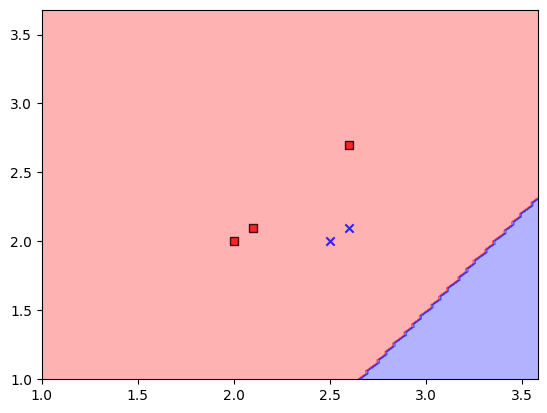

In [ ]:
cluster_1 = np.array([[2, 2],[2.6 , 2.7], [2.1, 2.1]])
cluster_2 = np.array([[2.5, 2], [2.6, 2.1]])

# Combine the clusters to form the dataset
a = np.vstack([cluster_1, cluster_2])
b = np.array([0, 0, 0, 1, 1])

# Initialize the logistic regression model
model = LogisticRegression(C=1)

# Fit the model
model.fit(a, b)
plot_decision_regions(a,b,model)

In [ ]:
# Grader's area
maxScore = maxScore + 4

# M[3,4] =

-----------------------
-----------------------
-----------------------


##  <font color = 'blue'> **Question 4. SVC and classification margin**  </font>

The Iris dataset defined in the above cells is linearly separable.

<font color = 'blue'> **Q4-1.**  </font> Use a [linear SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) to learn a hyperplane $y=w_1x_1 +w_2x_2 +b$ that maximizes the margin for this Iris dataset. In your answer, specify a setting for the hyperparameter $C$ that reduces the amount of regularization (that is, incentivizes very small slacks).

<font color = 'blue'> **Q4-2.** </font> Extract the coefficients $w$ and the intercept $b$ from the learned SVC. Find the the 2-norm of $w$: let $s = \|w\|_2$.
[Hint: Read the documentation in order to access the coefficients.]

<font color = 'blue'> **Q4-3.** </font> Set $w \leftarrow w/s$ and $b\leftarrow b/s$. This changes the numerical definition of the separation line, but the line is still the same.  

<font color = 'blue'> **Q4-4.** </font> With the new $w$ and $b$, calculate $wx^T + b$ for each point $x$ in our dataset. This will give a range of values; let $\gamma$ be the smallest of these in absolute value. This $\gamma$ is the margin. (In fact, there should be two points $x_1$ and $x_2$ of different labels, that give $wx_1^T + b = \gamma$ and $wx_1^T + b = -\gamma$.)


**Note:** as with anything else, feel free to discuss this on Canvas.

(If for this question you have used LLMs such as ChatGPT, replace this text by screenshots of the full transcript of your session. Create extra text cells if needed.)

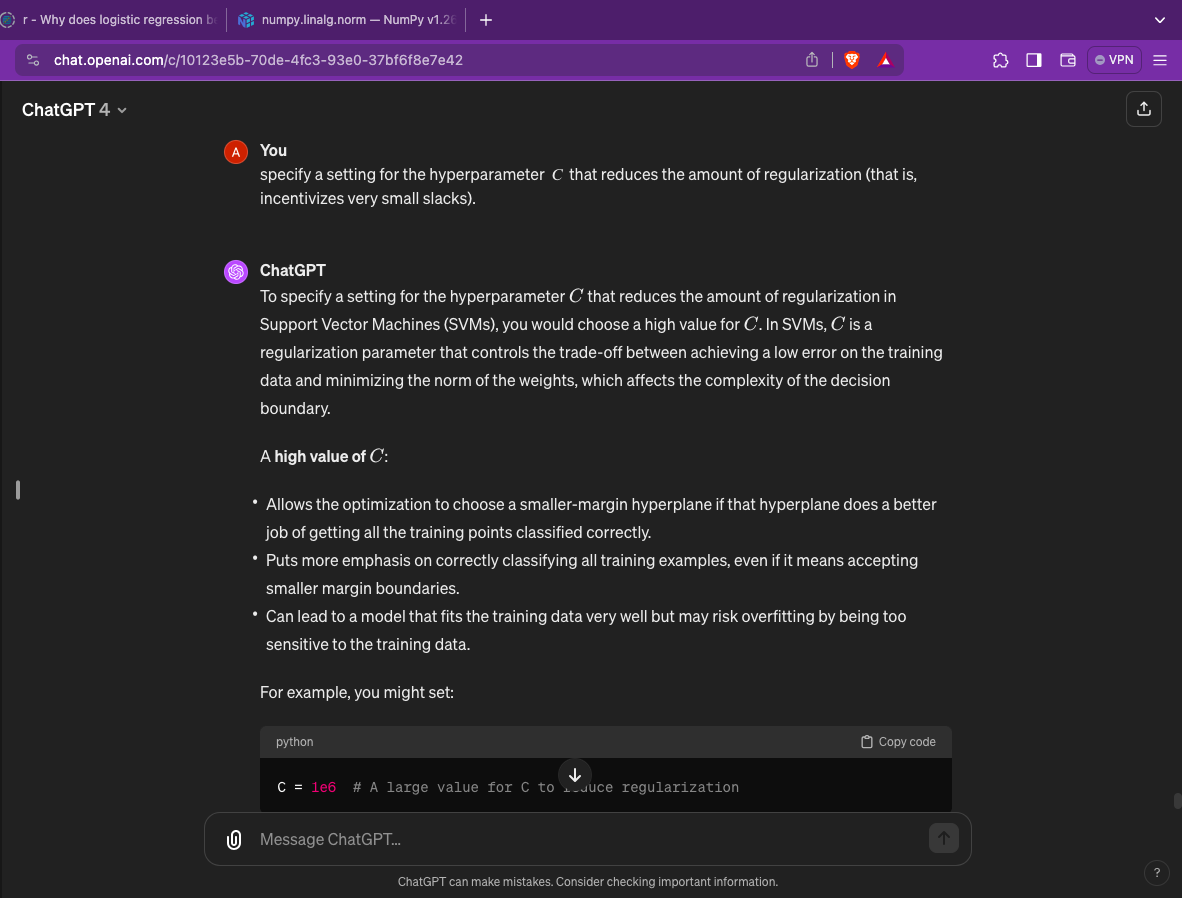

In [ ]:
Image('/content/drive/MyDrive/ML/assignment3/Screenshot 2024-03-10 at 8.59.36 PM.png')

Best C: 0.01


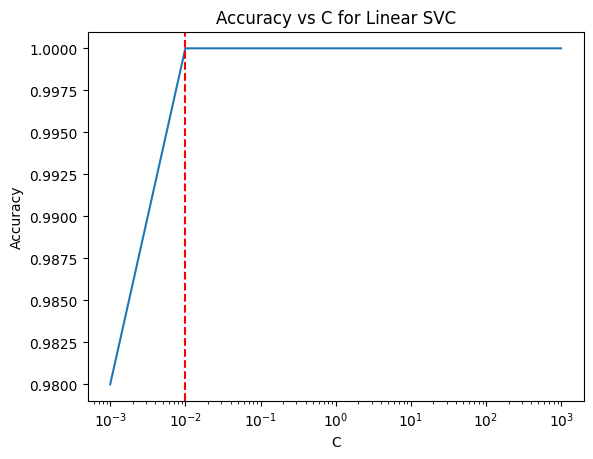

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
C_range = np.logspace(-3, 3, 7)


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    LinearSVC(max_iter=10000, random_state=42, dual=False),  # dual=False for cases where n_samples > n_features
    param_grid={'C': C_range},
    cv=skf,
    scoring='accuracy')

grid_search.fit(X, y)

best_C = grid_search.best_params_['C']
print("Best C: {}".format(best_C))


plt.semilogx(C_range, grid_search.cv_results_['mean_test_score'])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.axvline(x=0.01, color='r', linestyle='--', label='Best C = 0.01')
plt.title('Accuracy vs C for Linear SVC')
plt.show()

#### Any C greater than 0.01 will reduce regulartization

In [ ]:
req_model = LinearSVC(C=best_C, random_state=42)
req_model.fit(X,y)

w = req_model.coef_[0]
b = req_model.intercept_[0]
s = np.linalg.norm(w)

In [ ]:
w

array([-0.2655326 ,  0.56312335])

In [ ]:
b

-0.10458066655320183

In [ ]:
s

0.6225877170730535

In [ ]:
w = w/s
b = b/s

In [ ]:
req_Cal = np.dot(X,w) + b
gamma = np.min(np.abs(req_Cal))

In [ ]:
print("The margin gamma is:", gamma)

The margin gamma is: 0.370346372311158


In [ ]:
indices = np.argsort(np.abs(req_Cal))[:2]
x1, x2 = X[indices]

x1, x2

(array([5.1, 3. ]), array([4.8, 1.9]))

In [ ]:
# Grader's area

maxScore = maxScore + 16
#M[4,1] =
#M[4,2] =
#M[4,3] =
#M[4,4] =


-----------------------
-----------------------
-----------------------


##  <font color = 'blue'> **Question 5. Upper bound for perceptron errors before convergence**  </font>

In this problem we will use the margin $\gamma$ as calculated in Question 4. If you have not been able to calculate it, you can 'borrow' its value from someone else that has calculated it. (Feel free to share your calculated value of $\gamma$ on Canvas, or to ask your peers to share theirs.)

<font color = 'blue'> **Q5-1.** </font> Calculate $R = \max_{x\in X} \|x\|_2$. In other words, find the 2-norm of all points in the dataset, and let $R$ be the maximum norm.

<font color = 'blue'> **Q5-2.** </font> Calculate $\mathit{maxErrors} = R/\gamma^2$. This is the maximum number of errors that a perceptron can do, in the worst case, before it convergences.

<font color = 'blue'> **Q5-3.** </font> Compare $\mathit{maxErrors}$ with the actual number of errors that the perceptron does with a random initialization. [Hint: Re-use the code from Assignment 2, or anything else that can provide you with that number].  


(If for this question you have used LLMs such as ChatGPT, replace this text by screenshots of the full transcript of your session. Create extra text cells if needed.)

In [ ]:
# your answers go here

In [ ]:
norms = np.linalg.norm(X, axis=1)
R = np.max(norms)
R

8.462860036654275

In [ ]:
maxErrors = R / (gamma**2)
print(maxErrors)

61.70224537250649


In [ ]:
class Perceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state


    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []
        ###### Code for initializing number of training iterations and history of weights
        self.training_iter = 0
        self.weightHistory = [self.w_.copy()]
        ######
        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                #### Code to calculate the value of the perceptron
                valueOfPerceptron = self.predict(xi)
                ###### Code to check if the predicted value differs from the target value, if so, then we update the weights and their history.
                if valueOfPerceptron != target:
                  update = self.eta * (target - valueOfPerceptron)
                  errors += 1
                  self.w_[1:] += update * xi
                  self.w_[0] += update
                  self.weightHistory.append(self.w_.copy())
                ######
            ###### Code to increment the counter for number of training iterations and updat the list that tracks the number of errors in each iteration of the dataset
            self.training_iter += 1
            self.errors_.append(errors)
            ######
            ###### Code to break the loop after convergence
            if errors == 0:
              break
            ######
            ###### New code for doing nothing. - MEH
            this_code_does_nothing = True
            ######

        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

In [ ]:
X[:3]

array([[5.1, 1.4],
       [4.9, 1.4],
       [4.7, 1.3]])

In [ ]:
y[:3]

array([-1, -1, -1])

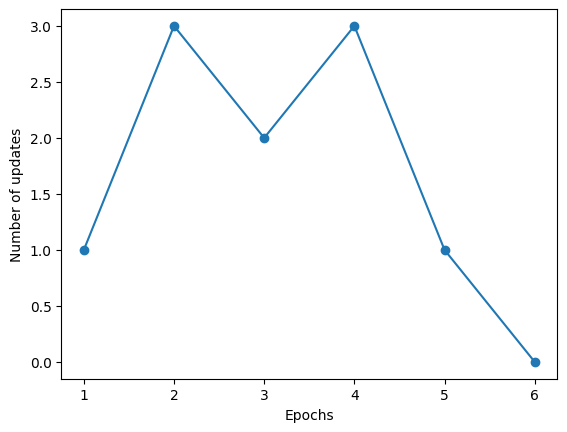

In [ ]:
perc = Perceptron(eta=0.0009, n_iter=30, random_state=1)
perc.fit(X,y)
plt.plot(range(1, len(perc.errors_) + 1), perc.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')
plt.show()

In [ ]:
print(sum(perc.errors_) < maxErrors)

True


In [ ]:
# Grader's area

maxScore = maxScore + 12
#M[5,1] =
#M[5,2] =
#M[5,3] =



----------------------------
----------------------------
----------------------------

In [ ]:
#Grader's area

rawScore = np.sum(M)
score = rawScore*100/maxScore